Carregamento das bibliotecas

In [147]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext import datasets
from string import punctuation
from torch.utils.data import DataLoader, TensorDataset

Carregamengo do dataset

In [148]:
train_iter, test_iter = datasets.IMDB()

Conversão para tipagem do Pandas

In [149]:
df_train = pd.DataFrame(train_iter, columns=['target','value'])

In [150]:
df_test = pd.DataFrame(test_iter, columns=['target','value'])
df_test.head()

,target,value
0,neg,I love sci-fi and am willing to put up with a ...
1,neg,"Worth the entertainment value of a rental, esp..."
2,neg,its a totally average film with a few semi-alr...
3,neg,STAR RATING: ***** Saturday Night **** Friday ...
4,neg,"First off let me say, If you haven't enjoyed a..."


Une ambos os dataset's em um único

In [151]:
df_data = df_train.append(df_test)

df_data.head()

,target,value
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


Código para obter apenas uma quantidade de exemplares de cada classe

In [152]:
# df_data = df_data.groupby('target').apply(lambda s: s.sample(10000))

Plotagem de distribuição dos dados

In [153]:
df_data.target.value_counts()

neg    25000
pos    25000
Name: target, dtype: int64

<AxesSubplot:>

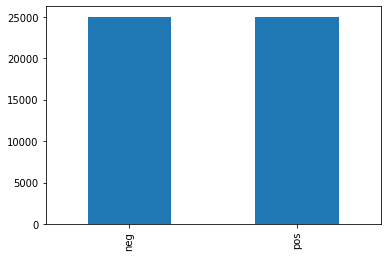

In [154]:
df_data.target.value_counts().plot.bar()

Aplica um pré-processamento nos dados, tais como:

* Remoção de pontuação
* definição do texto todo para minúsculo

In [155]:
def preprocess_data(x):
    all_text = ''.join(c for c in x if c not in punctuation)
    return all_text.lower()

df_data = df_data.assign(value = df_data.value.apply(lambda x: preprocess_data(x)))
df_data.head()

,target,value
0,neg,i rented i am curiousyellow from my video stor...
1,neg,i am curious yellow is a risible and pretentio...
2,neg,if only to avoid making this type of film in t...
3,neg,this film was probably inspired by godards mas...
4,neg,oh brotherafter hearing about this ridiculous ...


Cria uma tokenização com todas as palavras. A ideia é verificar as palavras mais comuns e como estão distribuídas

In [156]:
from collections import Counter

# Junta todos os textos
all_text = ' '.join(df_data.value.values)

# Separa por palavras
words = all_text.split()

# Faz a contagem por palavras
count_words = Counter(words)

# Total de palavras
total_words = len(words)

# Faz a ordenação de palavras
sorted_words = count_words.most_common(total_words)

Faz uma conversão das palavras para serem representadas por um valor numérico inteiro, iniciando em 1

In [157]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

Aplica a transformação de valores para inteiro nos reviews

In [158]:
reviews_int = []

for review in df_data.value.values:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)

print(reviews_int[0])

[9, 1501, 9, 226, 51851, 35, 53, 386, 1095, 83, 4, 31, 1, 6453, 11, 3541, 8, 50, 8, 13, 87, 607, 7, 7836, 9, 80, 537, 11, 30, 87, 8, 13, 23503, 32, 169, 9265, 43, 8, 120, 742, 5, 2254, 10, 686, 1498, 106, 3, 320, 4, 95, 1174, 2865, 9, 62, 67, 5, 64, 10, 16, 15708, 12, 1, 114, 6, 5762, 181, 3, 182, 3616, 476, 1425, 756, 5997, 36, 478, 5, 828, 263, 58, 68, 42, 119, 7, 835, 58, 478, 5, 1127, 41, 15073, 5, 251, 46, 418, 4, 657, 20, 48, 1, 859, 26431, 194, 42, 734, 987, 1230, 136, 14, 1, 2444, 310, 2, 1392, 1230, 7, 1, 2195, 1585, 7, 197, 2110, 5998, 2, 1806, 21911, 4, 19962, 42, 63, 3990, 20, 2517, 58, 44, 381, 15, 41, 476, 1643, 9482, 2, 1045, 11683, 12, 48, 1116, 69, 42, 9, 226, 51851, 6, 11, 1973, 151, 605, 10, 13, 1174, 8101, 62, 1, 381, 2, 1051, 134, 23, 167, 2, 224, 197, 54, 90, 29, 21, 315, 38, 46, 6935, 92, 3904, 133, 53, 27652, 337, 159, 8, 1540, 7, 615, 381, 2, 1051, 23, 3, 630, 8548, 7, 3616, 450, 54, 11861, 3748, 4677, 63, 1439, 5, 49, 168, 438, 308, 1838, 67, 381, 134, 7, 24, 

Faz o encoding dos label's para inteiro

In [159]:
encoded_labels = [1 if label == 'pos' else 0 for label in df_data.target.values]
encoded_labels = np.array(encoded_labels)

Faz um plot dos dados para verificar como estão as distribuições. É possível ver que o gráfico não está normalizado, o que significa que possuem outliers.

Outro detalhe importante é que dá para ver que tem alguns reviews que são muito longos.

Partindo disto, a ideia é removermos esses reviews com muito ou pouco review

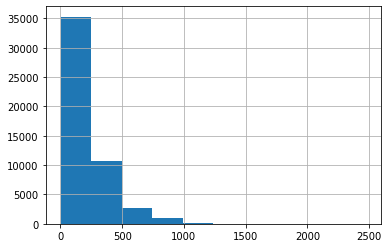

count    50000.000000
mean       230.258240
std        170.663887
min          4.000000
25%        126.000000
50%        172.000000
75%        280.000000
max       2469.000000
dtype: float64

In [160]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()

pd.Series(reviews_len).describe()

In [162]:
# Remove todo review que não tiver, ao menos 1 palavra
reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l > 0]
encoded_labels = [encoded_labels[i] for i, l in enumerate(reviews_len) if l > 0]

Efetua o processo de padding/truncate dos dados. A ideia é que todos os reviews fiquem com o mesmo tamanho, afinal, o objeto da rede neural é que a entrada seja um número fixo de neurônios

In [164]:
# O valor padrão do seq_length é baseado no 3º quartil
def pad_features(reviews_int, seq_length=280):
    # Cria uma matriz zerada - a ideia é que, os espaços vazios sejam preenchidos com 0
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    for i, review in enumerate(reviews_int):
        reviews_len = len(review)

        if reviews_len <= seq_length:
            zeroes = list(np.zeros(seq_length - reviews_len))
            new = zeroes + review
        elif reviews_len > seq_length:
            new = review[0:seq_length]
        
        features[i, :] = np.array(new)
    
    return features

Aqui, a lista de features ficará com 280 de tamanho, para cada review

In [165]:
features = pad_features(reviews_int)
len_feats = len(features)

In [166]:
len(features), len(features[0])

(50000, 280)

Separa em Train, Valid, Test

* 80% para treino
* 10% para valid
* 10% para test

In [167]:
SPLIT_FRAC = 0.8

FACTOR = int(SPLIT_FRAC * len_feats)

train_x = np.array(features[0:FACTOR])
train_y = np.array(encoded_labels[0:FACTOR])

remain_x = np.array(features[FACTOR:])
remain_y = np.array(encoded_labels[FACTOR:])

REMAIN_FACTOR = int(len(remain_x) * 0.5)

valid_x = np.array(remain_x[0:REMAIN_FACTOR])
valid_y = np.array(remain_y[0:REMAIN_FACTOR])

test_x = np.array(remain_x[REMAIN_FACTOR:])
test_y = np.array(remain_y[0:REMAIN_FACTOR:])

Visualiza o tamanho dos dataset's de treino, validação e teste

In [168]:
print(len(train_x), len(train_x[0]))
print(len(valid_x), len(valid_x[0]))
print(len(test_x), len(test_x[0]))

40000 280
5000 280
5000 280


Dataloaders e batching

A ideia de fazer o drop_last é com intuito de ter todos os batches com o mesmo tamanho.

In [169]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data  = TensorDataset(torch.from_numpy(test_x),  torch.from_numpy(test_y))

BATCH_SIZE = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader  = DataLoader(test_data,  shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [170]:
# Exibição de um exemplo de dados

data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: ', sample_x)
print('Sample label size: ', sample_y.size())
print('Sample label: ', sample_y)

Sample input size:  torch.Size([64, 280])
Sample input:  tensor([[    0,     0,     0,  ...,   181,    45,    47],
        [    0,     0,     0,  ...,   535, 26148,   155],
        [    0,     0,     0,  ...,     4,    10,    17],
        ...,
        [    0,     0,     0,  ...,    26,   546,   760],
        [ 2608,  8243,     1,  ..., 11014,    36,   658],
        [    0,     0,     0,  ...,    45,     4,   723]])
Sample label size:  torch.Size([64])
Sample label:  tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0])


Define o modelo da classe

In [171]:
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        # Efetua a inicializacao do modelo
        super().__init__()

        # Define a quantidade de neuronios de saida, numero de layers e tamanho da camada escondida
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Cria o Embedding e a LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Define um dropout de 0.3, para apagar uma parte dos pesos
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        # Define o funcionamento do modelo
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden
    
    # Define e inicializa as camadas ocultas
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(), 
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Treinamento da rede, inicia com a definição dos parâmetros, como tamanho total do vocabulário, quantidade de neurônios nas camadas escondidas e de saída, número de camadas

In [172]:
VOCAB_SIZE = len(vocab_to_int) + 1 # porque o indice inicia em 0 e deve ser iniciado em 1
OUTPUT_SIZE = 1
EMBEDDING_DIM = 400
HIDDEN_DIM = 128
N_LAYERS = 4

model = SentimentLSTM(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS)
model

SentimentLSTM(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 128, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [173]:
LR = 0.001 #Definicao do fator de aprendizado
PRINT_EVERY = 100 
CLIP = 5 # Define a norma máxima dos gradientes

# Define o criterio de cálculo de loss - BCE - Binary Cross Entropy, usado para classificacao de 2 classes
criterion = nn.BCELoss()

# Utiliza o otimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Quantidade de épocas
epochs = 10
counter = 0

model.train()

# itera as epocas
for e in range(epochs):
    print('epoch: {0}'.format(e))
    
    h = model.init_hidden(BATCH_SIZE)

    # itera o loader de treinamento
    for inputs, labels in train_loader:
        counter += 1

        h = tuple([each.data for each in h])
        model.zero_grad()

        inputs = inputs.type(torch.LongTensor)
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        # Verifica se é para efetuar o processo de validacao (por padrao, a cada 100 iteracoes de treinamento, 1 faz a validacao)
        if counter % PRINT_EVERY == 0:
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []

            model.eval()

            # Itera sobre o data loader de validacao
            for inputs, labels in valid_loader:
                # Obtem a entrada, faz a predicao do modelo e computa a loss
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.type(torch.LongTensor)
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())
            
            # Retorna para treinamento
            model.train()

            # Exibe o estado
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

epoch: 0
Epoch: 1/10... Step: 100... Loss: 0.609037... Val Loss: 0.974583
Epoch: 1/10... Step: 200... Loss: 0.676484... Val Loss: 1.041060
Epoch: 1/10... Step: 300... Loss: 0.453250... Val Loss: 0.675144
Epoch: 1/10... Step: 400... Loss: 0.468367... Val Loss: 1.011498
Epoch: 1/10... Step: 500... Loss: 0.544220... Val Loss: 0.325990
Epoch: 1/10... Step: 600... Loss: 0.359136... Val Loss: 0.395054
epoch: 1
Epoch: 2/10... Step: 700... Loss: 0.267234... Val Loss: 0.904478
Epoch: 2/10... Step: 800... Loss: 0.230600... Val Loss: 0.615921
Epoch: 2/10... Step: 900... Loss: 0.317629... Val Loss: 0.400452
Epoch: 2/10... Step: 1000... Loss: 0.490504... Val Loss: 0.546991
Epoch: 2/10... Step: 1100... Loss: 0.274251... Val Loss: 0.546520
Epoch: 2/10... Step: 1200... Loss: 0.315838... Val Loss: 0.712836
epoch: 2
Epoch: 3/10... Step: 1300... Loss: 0.180360... Val Loss: 0.370921
Epoch: 3/10... Step: 1400... Loss: 0.184212... Val Loss: 0.757051
Epoch: 3/10... Step: 1500... Loss: 0.151596... Val Loss: 0

Apos o modelo treinado, executa na base de testes

In [174]:
test_losses = []
num_correct = 0

h = model.init_hidden(BATCH_SIZE)

model.eval()

# Itera a base de testes
for inputs, labels in test_loader:
    # Obtem um valor e executa a inferencia no modelo
    h = tuple([each.data for each in h])
    
    inputs = inputs.type(torch.LongTensor)
    output, h = model(inputs, h)
    
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # Converte para a classe de resultado - 0 ou 1
    pred = torch.round(output.squeeze())
    
    # Checa com o valor original se esta correto e atualiza as contagens
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)

# Exibe as estatísticas de loss e acurácia
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Exibe a acuracia do modelo
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.062
Test accuracy: 0.783


Salva o melhor modelo no disco

**Importante**: Foi definido, como boa prática, salvar o modelo completo e não apenas os seus pesos.

In [176]:
PATH = './models/lstm_sentiment_analysis_1.h5'

torch.save(model, PATH)

Por fim, efetua a criacao do metodo de predicao, que recebe uma string, com base no modelo salvo.

É possível observar que é feito o método `tokenize_review` que faz o mesmo pré-processamento realizado na etapa de treinamento, validação e testes.

In [178]:
def tokenize_review(review):
    review = review.lower()
    txt = ''.join([c for c in review if c not in punctuation])
    words = txt.split()
    
    
    ints = []
    
    # Neste passo, filtra todas as palavras contidas no vocabulario
    # Caso nao seja incluida, o valor fica como 0
    ints.append([vocab_to_int[word] if vocab_to_int[word] != None else 0 for word in words])

    return ints


def predict(model, input_str, seq_length=280):
    # Recebe o modelo e uma entrada de string
    # O parametro seq_length deve ser o mesmo atribuido no treino e teste - 
    # corresponde ao tamanho maximo do texto
    
    print(input_str)
    model_loaded.eval()
    
    # faz o pre processamento
    ints = tokenize_review(input_str)
    
    # Extrai as features
    features = pad_features(ints, seq_length)
    
    # Converte para tensor
    feature_tensor = torch.from_numpy(features)
    
    # Inicia a predicao do modelo
    batch_size = feature_tensor.size(0)
    
    h = model.init_hidden(batch_size)
    
    output, h = model(feature_tensor, h)
    
    # Arrendonda o valor predito - por ser sigmoid, vira entre 0 e 1, entao arredendo para ficar mais proximo do resultado
    pred = torch.round(output.squeeze())
    
    print('Predicted value: {:.6f}'.format(output.item()))
    
    # faz a verificacao do que foi predito e exibe o resultado
    if (pred.item() > 0):
        print('Positive Review')
    else:
        print('Negative Review')

model_loaded = torch.load(PATH)
predict(model_loaded, 'This movie had the best acting and the dialogue was so good. I loved it.')
predict(model_loaded, 'This movie was so terrible.')

This movie had the best acting and the dialogue was so good. I loved it.
Predicted value: 0.997554
Positive Review
This movie was so terrible.
Predicted value: 0.003912
Negative Review
